In [21]:
!pip install -q selectivesearch
!pip install -q torch_snippets
!pip install -q torch_summary
from torchsummary import summary
import selectivesearch
from skimage.segmentation import felzenszwalb
import torch
from torch.optim import AdamW
from torchvision import transforms, datasets, models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.ops import nms 
from torch.utils.data import Dataset, DataLoader
from torch_snippets import *
import cv2
import matplotlib.pyplot as plt 
import matplotlib.patches as patches 
import numpy as np
import pandas as pd

In [2]:
!pip install -q torch_snippets

from torch_snippets import *

In [4]:
img = cv2.imread('/kaggle/input/hemanvi/Hemanvi.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
segments = felzenszwalb(img, 200)

Text(0.5, 1.0, 'Segments')

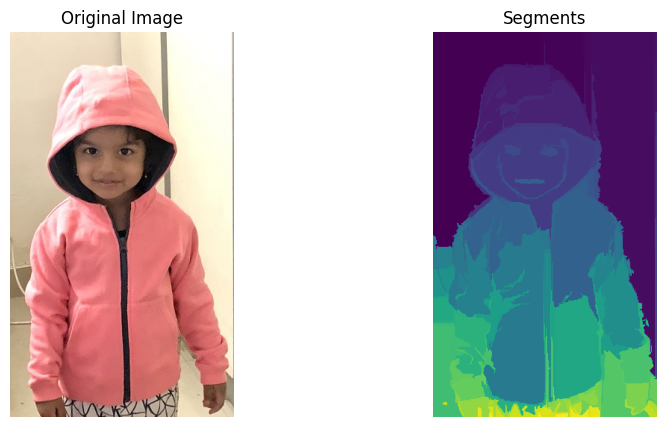

In [5]:
fig, axes = plt.subplots(1, 2 ,figsize = (10, 5))

axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')

axes[1].imshow(segments)
axes[1].axis('off')
axes[1].set_title('Segments')

In [6]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale = 200, min_size = 100)
    
    img_area = np.prod(img.shape[:2])
    candidates = []
    
    for r in regions: #r is a dict
        if r['rect'] in candidates : continue 
        if r['size'] < 0.05 * img_area : continue
        if r['size'] > 0.95 * img_area : continue
        
        x, y, h, w = r['rect']
        candidates.append(list(r['rect']))
    return candidates

/opt/conda/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


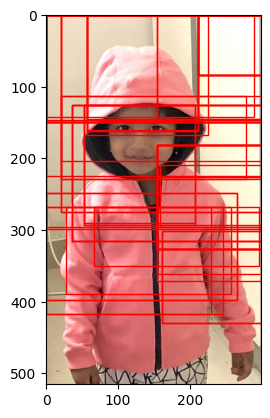

In [7]:
candidates = extract_candidates(img)
fig, ax = plt.subplots(1)


ax.imshow(img)

for c in candidates:
    x, y, h, w = c
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Show plot
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
img_root = '/kaggle/input/open-images-bus-trucks/images/images'
df_raw = pd.read_csv('/kaggle/input/open-images-bus-trucks/df.csv')
print(df_raw.shape)
df_raw.head()

(24062, 21)


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [23]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=img_root):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

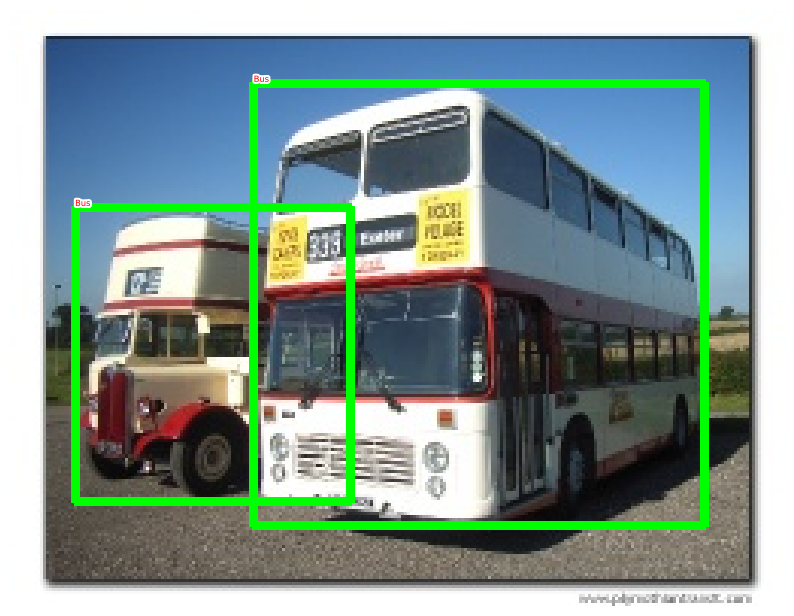

In [24]:
ds = OpenImages(df_raw)
img, boxes, classes, _ = ds[500]
show(img, bbs = boxes, texts = classes, sz = 10)

In [5]:
#test cell
img_id =  df_raw['ImageID'].unique()[500] 
img_path = img_root + '/' + img_id + '.jpg'
img = cv2.imread(img_path)
h, w, _ = img.shape
df = df_raw[df_raw['ImageID'] == img_id]
box = df['XMin,XMax,YMin,YMax'.split(',')].values
(boxes * np.array([w, h, w, h])).astype(np.uint16).tolist() #scales the values in boxes
box

array([[0.084375, 0.4375  , 0.330894, 0.822764],
       [0.315625, 0.8975  , 0.126016, 0.864228]])

In [25]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
def get_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [ ]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[get_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{img_root}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [9]:
#test cell
for ix, (img, bbs, labels, fpaths) in enumerate(ds): break

candidates = extract_candidates(img)
candidates = np.array([(x, y, x + w, y + h) for (x, y, w, h) in candidates]) #(43, 4)
ious = np.array([[get_iou(candidate, _bb) for candidate in candidates] for _bb in bbs]).T #(1, 43) before transpose 
#we are taking 2nd candidate (index 1) for the example 
candidate_ious = ious[1]
labels

/opt/conda/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


['Bus']

In [27]:
[f'{img_root}/{stem(FPATHS[0])}.jpg']

['/kaggle/input/open-images-bus-trucks/images/images/0000599864fd15b3.jpg']

In [28]:
pd.DataFrame(flatten(CLSS), columns = ['label'])['label'].unique()

array(['Bus', 'background', 'Truck'], dtype=object)

In [29]:
FPATHS = [f'{img_root}/{stem(FPATHS[i])}.jpg' for i in range(len(FPATHS))]
FPATHS, GTBBS, DELTAS, CLSS, ROIS = [i for i in [FPATHS, GTBBS, DELTAS, CLSS, ROIS]]

targets = pd.DataFrame(flatten(CLSS), columns = ['label'])
label2target = {l : t for t, l in enumerate(targets['label'].unique())}
target2label = {t : l for l, t in label2target.items()}
background_class = label2target['background']

In [11]:
#test cell
(img, bbs, labels, fpaths) = ds[234]
candidates = extract_candidates(img) #contains all the different bounding boxes all over the image as seen in the Hemanvi picture 
candidates = np.array([(x, y, x + w, y + h) for x, y, w, h in candidates]) #creating Xmin, Ymin, Xmax, Ymax since that's the format get_iou() expects
ious, rois, deltas, clss = [],[],[],[]
ious = np.array([[get_iou(candidate, _bb) for candidate in candidates] for _bb in bbs]).T
candidate = candidates[21]
candidate_ious = ious[21]
fpaths

/opt/conda/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


'/kaggle/input/open-images-bus-trucks/images/images/00e2de0a281f485e.jpg'

In [30]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
def preprocess(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    img = torch.unsqueeze(img, dim = 0)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [ ]:
pic = np.random.randn(3, 156, 289)
cv2.resize(pic, (224, 224))

In [31]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, deltas, labels, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = self.fpaths[ix]
        image = cv2.imread(fpath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess(crop/255.) for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [ ]:
#test cell
roi = ROIS[9]
fpath = FPATHS[9]
img = cv2.imread(fpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W, _ = img.shape
sh = np.array([W, H, W, H])
bbs = (roi * sh).astype(np.uint16)
for (x, y, X, Y) in bbs:
    break
img.shape
CLSS

In [32]:
n_train = int(0.9*len(FPATHS))
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], DELTAS[:n_train],CLSS[:n_train], GTBBS[:n_train])
val_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], DELTAS[n_train:], CLSS[n_train:],  GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
tr_dl = DataLoader(train_ds, batch_size=5, collate_fn=train_ds.collate_fn, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=5, collate_fn=val_ds.collate_fn, drop_last=True)

In [ ]:
next(iter(tr_dl))


In [41]:
vgg_backbone = models.vgg16(weights = 'DEFAULT')
vgg_backbone.classifier = nn.Sequential()
        
for p in vgg_backbone.parameters():
    p.requires_grad = False

vgg_backbone.eval().to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(vgg_backbone, (3, 224, 224))

In [70]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 2048),
#               nn.GroupNorm(2048 // 4, 2048),
              nn.ReLU(),
#               nn.Linear(2048, 1024),
#               nn.GroupNorm(1024 // 4, 1024),
#               nn.ReLU(),
#               nn.Dropout(0.1),
              nn.Linear(2048, 1024),
              nn.ReLU(),
              nn.Linear(1024, 512),
#               nn.GroupNorm(512 // 4, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.ReLU(),
#               nn.Dropout(0.1)
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat).float()
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        probs = probs.float()
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [48]:
def train_batch(inputs, model, opt, loss_func):
    model.train()
    input, clss, deltas = inputs
    cls_score, bbox = model(input)
    loss, loc_loss, regr_loss = loss_func(cls_score, bbox, clss, deltas)
    opt.zero_grad()
    loss.backward()
    opt.step()
    accs = clss == decode(cls_score)
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()    

In [45]:
@torch.no_grad()
def validate_batch(model, inputs, loss_func):
    model.eval()
    input, clss, deltas = inputs 
    cls_score, bbox = model(input)
    loss, loc_loss, regr_loss = loss_func(cls_score, bbox, clss, deltas,)
    _, _clss = cls_score.max(-1)
    
    acc = clss == _clss
    return _clss, deltas, loss.detach(), loc_loss, regr_loss, acc.cpu().numpy()

The number of parameters in this model is 68797255
EPOCH: 7.000  val_loss: 2.356  val_loc_loss: 0.483  val_regr_loss: 0.187  val_acc: 0.824  (525.25s - 0.00s remaining)))

100%|██████████| 108/108 [00:00<00:00, 3467.19it/s]


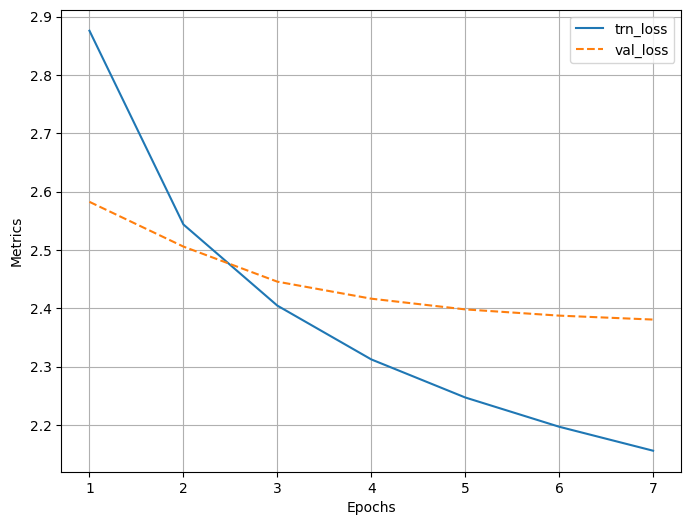

In [71]:
rcnn = RCNN().to(device)
# for p in rcnn.parameters():
#     if p.dim() > 1:
#         nn.init.kaiming_normal_(p)

print(f'The number of parameters in this model is {sum(p.numel() for p in rcnn.parameters())}')
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 7
log = Report(n_epochs)

for epoch in range(n_epochs):

    _n = len(tr_dl)
    for ix, inputs in enumerate(tr_dl):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(val_dl)
    for ix,inputs in enumerate(val_dl):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(rcnn,inputs, 
                                                 criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [20]:
print(f'The number of parameters in this model is {sum(p.numel() for p in rcnn.parameters())}')

The number of parameters in this model is 26139207


1 - tr -> 1.8, val -> 2.75 <br>
2 - tr -> 1.4, val -> 2.25 <br>
3 - tr -> 1.25, val -> 2.05 <br>
4 - tr -> 1.85, val -> 2.25. the best we have. <br>
next, maybe try some more dropout.
also try resnet with group normalization.

In [23]:
rcnn = RCNN().to(device)
print(f'The number of parameters in this model is {sum(p.numel() for p in rcnn.parameters())}')

The number of parameters in this model is 59703879


In [77]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess(crop/255.))
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

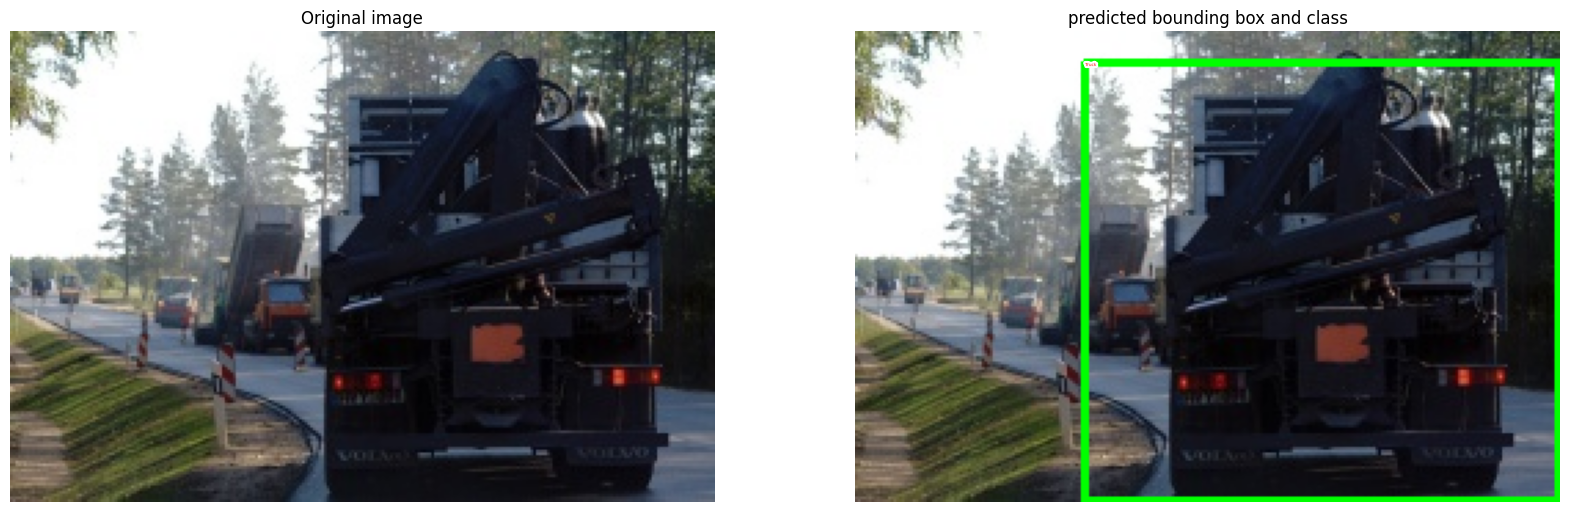

((83, 11, 255, 170), 'Truck', 0.917352)

In [89]:
image, crops, bbs, labels, deltas, gtbbs, fpath = val_ds[19]
test_predictions(fpath)